In [1]:
# !pip install catboost optuna















     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.2 MB/s eta 0:00:00





















     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 18.8 MB/s eta 0:00:00






































































     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.1 MB/s eta 0:00:00































































     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00











































































































In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb

# import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_auc_score, accuracy_score, silhouette_score, classification_report

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

# import optuna

from scipy.spatial.distance import pdist, squareform

import pickle

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from scipy.sparse import csr_matrix, coo_matrix


2024-06-25 04:57:16.489918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 04:57:16.490038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 04:57:16.590296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

Resources:  https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

### Load and Clean Data

#### General

In [2]:
# datapath = './data/' # local, sagemaker
# datapath = r'/content/drive/MyDrive/Colab Notebooks/DD_earthquake_data/' # colab
datapath = r'/kaggle/input/' # kaggle

df_train_features_raw = pd.read_csv(datapath+'train_values.csv').set_index('building_id')
df_train_labels_raw = pd.read_csv(datapath+'train_labels.csv').set_index('building_id')
df_test_features_raw = pd.read_csv(datapath+'test_values.csv').set_index('building_id')

- No missing data to fill

In [3]:
def preprocess(df_features):
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    return df_features

def preprocess_autoencode(df_features):
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    return df_features

def preprocess_NN_cat2vec(df_features):
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_features.dtypes):
        if dtype in ['int64','object']:
            categorical_features_indices.append(i)
            
    categorical_features = []
    for colname,dtype in zip(df_features.columns,df_features.dtypes):
        if dtype in ['int64','object']:
            categorical_features.append(colname)

    geo_features = ['geo_level_1_id','geo_level_2_id','geo_level_3_id']
    df_features = pd.get_dummies(df_features,columns=[col for col in categorical_features if not (col in geo_features)],drop_first=True)
    return df_features, categorical_features

def preprocess_target_encode(df_features):
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_features.dtypes):
        if dtype in ['int64','object']:
            categorical_features_indices.append(i)
            
    categorical_features = []
    for colname,dtype in zip(df_features.columns,df_features.dtypes):
        if dtype in ['int64','object']:
            categorical_features.append(colname)

    geo_features = ['geo_level_1_id','geo_level_2_id','geo_level_3_id']
    df_features = pd.get_dummies(df_features,columns=[col for col in categorical_features if not (col in geo_features)],drop_first=True)
    return df_features, categorical_features

In [4]:
# Prep data for target_encode
geo_features = ['geo_level_1_id','geo_level_2_id','geo_level_3_id']
df_train_features, categorical_features = preprocess_target_encode(df_train_features_raw)
df_test_features,_ = preprocess_target_encode(df_test_features_raw)

non_geo_features = [col for col in df_train_features.columns if not (col in geo_features)]
numerical_features = ['count_floors_pre_eq','age', 'area_percentage','height_percentage','count_families']

all_geos = pd.concat([df_train_features[geo_features],df_test_features[geo_features]])
all_geos = all_geos.nunique()

X_train_or, X_test_or, y_train_or, y_test_or = train_test_split(df_train_features, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)

# # Standardize numerical features
# scaler = StandardScaler()
# X_train_or[non_geo_features] = scaler.fit_transform(X_train_or[non_geo_features])
# X_test_or[non_geo_features] = scaler.transform(X_test_or[non_geo_features])

In [5]:
all_geos = pd.concat([df_train_features_raw[geo_features],df_test_features_raw[geo_features]])

#### Target Encode

In [6]:
X_train = X_train_or.copy()
X_test = X_test_or.copy()
y_train = y_train_or.copy()
y_test = y_test_or.copy()
target = 'damage_grade'

full_train = pd.concat([X_train,y_train],axis=1)
# full_test = pd.concat([X_test,y_test],axis=1)

In [7]:
# Function to perform target encoding with smoothing for a given column against the target_column in a DataFrame
def target_encode_smooth(df, target_column, column, smoothing=1):
    """
    Perform target encoding with smoothing for a given column against the target_column in a DataFrame.
    
    Parameters:
    df (DataFrame): The input DataFrame containing both target_column and column.
    target_column (str): The name of the target column (to be encoded against).
    column (str): The name of the column to encode.
    smoothing (float): The smoothing parameter.
    
    Returns:
    dict: A dictionary mapping each unique value in 'column' to its smoothed target-encoded value.
    """
    # Calculate the global mean of the target variable
    global_mean = df[target_column].mean()
    
    # Calculate the number of values and the mean of each group
    agg = df.groupby(column)[target_column].agg(['mean', 'count'])
    counts = agg['count']
    means = agg['mean']
    
    # Compute the smoothed means
    smooth = (counts * means + smoothing * global_mean) / (counts + smoothing)
    
    # Return the mapping as a dictionary
    return smooth.to_dict()

# Apply target encoding with smoothing for the categorical column against each target column
categorical_column = 'geo_level_3_id'
target_columns = [col for col in full_train.columns if not (col in geo_features + numerical_features)]
# target_columns = ['damage_grade']
encoded_maps = {}

# Smoothing parameter
smoothing = 500

# Iterate over each target column and perform target encoding with smoothing
for target_column in target_columns:
    encoded_maps[target_column] = target_encode_smooth(full_train, target_column, categorical_column, smoothing)

In [8]:
geo_targ_encode = pd.DataFrame(encoded_maps)
geo_targ_encode.rename(columns={col:'geo3_'+col for col in geo_targ_encode.columns},inplace=True)
geo_targ_encode = geo_targ_encode.reset_index()
geo_targ_encode.rename(columns={'index':'geo_level_3_id'},inplace=True)

In [9]:
# Add encoding to features
X_train_geo_encode = X_train.merge(geo_targ_encode,on='geo_level_3_id',how='left')
X_train_geo_encode.drop(columns=['geo_level_3_id'],inplace=True)
X_test_geo_encode = X_test.merge(geo_targ_encode,on='geo_level_3_id',how='left')
X_test_geo_encode.drop(columns=['geo_level_3_id'],inplace=True)

In [12]:
# fig,ax = plt.subplots(1,1,figsize=(15,5))
# ax.plot(X_train_geo_encode.sort_values(['geo_level_1_id','geo_level_2_id','geo3_damage_grade']).reset_index(drop=True)['geo3_damage_grade']);

## CatBoost

### Use learnt embedding

In [14]:
pd.set_option('display.max_info_columns', 180)
X_train_geo_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221510 entries, 0 to 221509
Data columns (total 112 columns):
 #    Column                                         Non-Null Count   Dtype  
---   ------                                         --------------   -----  
 0    geo_level_1_id                                 221510 non-null  int64  
 1    geo_level_2_id                                 221510 non-null  int64  
 2    count_floors_pre_eq                            221510 non-null  float64
 3    age                                            221510 non-null  float64
 4    area_percentage                                221510 non-null  float64
 5    height_percentage                              221510 non-null  float64
 6    count_families                                 221510 non-null  float64
 7    land_surface_condition_o                       221510 non-null  bool   
 8    land_surface_condition_t                       221510 non-null  bool   
 9    foundation_type_i       

In [10]:
# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(X_train_geo_encode.dtypes):
    if dtype in ['int64','object','bool']:
        categorical_features_indices.append(i)
categorical_features = []
for colname,dtype in zip(X_train_geo_encode.columns,X_train_geo_encode.dtypes):
    if dtype in ['int64','object','bool']:
        categorical_features.append(colname)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=X_train_geo_encode, label=y_train, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=X_test_geo_encode, label=y_test, cat_features=categorical_features_indices)

In [11]:
# Smoothing 500
# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',task_type='GPU', devices='0', verbose=100)
# model = cb.CatBoostRegressor(loss_function='RMSE', verbose=100)


# Grid search training
grid = {'iterations': [1000],
        'learning_rate': [0.1],
        'depth': [6],
        'l2_leaf_reg': [0.2],
        'early_stopping_rounds':[50]}
model.grid_search(grid, train_dataset)

# Evaluation
pred = model.predict(X_test_geo_encode)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(pred)
# (pred_int == np.squeeze(y_test.to_numpy())).sum()/y_test.shape[0]
f1_score(y_test,pred_int,average='micro')
# f1_score(y_test,pred_int)

0:	learn: 2.1006245	test: 2.0955502	best: 2.0955502 (0)	total: 7.99s	remaining: 2h 13m 6s
100:	learn: 0.4308405	test: 0.4331521	best: 0.4331521 (100)	total: 11.4s	remaining: 1m 41s
200:	learn: 0.4254273	test: 0.4289825	best: 0.4289825 (200)	total: 14.6s	remaining: 58.1s
300:	learn: 0.4230442	test: 0.4275782	best: 0.4275782 (300)	total: 17.9s	remaining: 41.5s
400:	learn: 0.4215104	test: 0.4267593	best: 0.4267593 (400)	total: 21.2s	remaining: 31.6s
500:	learn: 0.4204924	test: 0.4263016	best: 0.4263016 (500)	total: 24.3s	remaining: 24.2s
600:	learn: 0.4197733	test: 0.4259790	best: 0.4259790 (600)	total: 27.5s	remaining: 18.2s
700:	learn: 0.4192049	test: 0.4257297	best: 0.4257282 (697)	total: 30.7s	remaining: 13.1s
800:	learn: 0.4187638	test: 0.4255512	best: 0.4255512 (800)	total: 33.8s	remaining: 8.39s
900:	learn: 0.4183154	test: 0.4254148	best: 0.4254148 (900)	total: 37s	remaining: 4.06s
999:	learn: 0.4180550	test: 0.4253442	best: 0.4253440 (998)	total: 40.1s	remaining: 0us
bestTest = 0.

0.7467191936762938

In [12]:
# Smoothing 1000
# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',task_type='GPU', devices='0', verbose=100)
# model = cb.CatBoostRegressor(loss_function='RMSE', verbose=100)


# Grid search training
grid = {'iterations': [1000],
        'learning_rate': [0.1],
        'depth': [6],
        'l2_leaf_reg': [0.2],
        'early_stopping_rounds':[50]}
model.grid_search(grid, train_dataset)

# Evaluation
pred = model.predict(X_test_geo_encode)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(pred)
# (pred_int == np.squeeze(y_test.to_numpy())).sum()/y_test.shape[0]
f1_score(y_test,pred_int,average='micro')
# f1_score(y_test,pred_int)

0:	learn: 2.1006245	test: 2.0955502	best: 2.0955502 (0)	total: 36.2ms	remaining: 36.1s
100:	learn: 0.4308405	test: 0.4331521	best: 0.4331521 (100)	total: 3.29s	remaining: 29.3s
200:	learn: 0.4254273	test: 0.4289825	best: 0.4289825 (200)	total: 6.5s	remaining: 25.9s
300:	learn: 0.4230442	test: 0.4275782	best: 0.4275782 (300)	total: 9.69s	remaining: 22.5s
400:	learn: 0.4215104	test: 0.4267593	best: 0.4267593 (400)	total: 12.9s	remaining: 19.2s
500:	learn: 0.4204924	test: 0.4263016	best: 0.4263016 (500)	total: 16.1s	remaining: 16s
600:	learn: 0.4198081	test: 0.4260118	best: 0.4260118 (600)	total: 19.2s	remaining: 12.7s
700:	learn: 0.4192257	test: 0.4258039	best: 0.4258039 (700)	total: 22.3s	remaining: 9.52s
800:	learn: 0.4188842	test: 0.4257196	best: 0.4257153 (790)	total: 25.4s	remaining: 6.31s
900:	learn: 0.4184824	test: 0.4255345	best: 0.4255317 (895)	total: 28.5s	remaining: 3.13s
999:	learn: 0.4180790	test: 0.4254497	best: 0.4254479 (997)	total: 31.5s	remaining: 0us
bestTest = 0.42544

0.7477424471105881

In [13]:
# Smoothing 500
# Instantiate catboost regressor model
# model = cb.CatBoostRegressor(loss_function='RMSE')
model = cb.CatBoostRegressor(loss_function='RMSE',task_type='GPU', devices='0', verbose=100)

# Grid search training
grid = {'iterations': [1000,1500],
        'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.01,0.2, 0.5],
        'early_stopping_rounds':[50]}
model.grid_search(grid, train_dataset)

# Evaluation
pred = model.predict(X_test_geo_encode)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(pred)
# (pred_int == np.squeeze(y_test.to_numpy())).sum()/y_test.shape[0]
f1_score(y_test,pred_int,average='micro')
# f1_score(y_test,pred_int)

0:	learn: 2.2551321	test: 2.2500749	best: 2.2500749 (0)	total: 21.9ms	remaining: 21.9s
100:	learn: 0.4689035	test: 0.4692267	best: 0.4692267 (100)	total: 2s	remaining: 17.8s
200:	learn: 0.4446916	test: 0.4461378	best: 0.4461378 (200)	total: 3.96s	remaining: 15.8s
300:	learn: 0.4391264	test: 0.4407288	best: 0.4407288 (300)	total: 5.95s	remaining: 13.8s
400:	learn: 0.4356129	test: 0.4373474	best: 0.4373474 (400)	total: 7.86s	remaining: 11.7s
500:	learn: 0.4333472	test: 0.4352015	best: 0.4352015 (500)	total: 9.8s	remaining: 9.77s
600:	learn: 0.4316034	test: 0.4335554	best: 0.4335554 (600)	total: 11.7s	remaining: 7.8s
700:	learn: 0.4303152	test: 0.4324158	best: 0.4324158 (700)	total: 13.7s	remaining: 5.86s
800:	learn: 0.4293243	test: 0.4316015	best: 0.4316015 (800)	total: 15.7s	remaining: 3.9s
900:	learn: 0.4284361	test: 0.4308319	best: 0.4308319 (900)	total: 17.6s	remaining: 1.94s
999:	learn: 0.4277959	test: 0.4303254	best: 0.4303254 (999)	total: 19.5s	remaining: 0us
bestTest = 0.43032541

0.7505308127190402

In [14]:
best_params = model.get_params()
best_params

{'loss_function': 'RMSE',
 'verbose': 100,
 'task_type': 'GPU',
 'devices': '0',
 'depth': 8,
 'od_wait': 50,
 'learning_rate': 0.1,
 'l2_leaf_reg': 0.01,
 'iterations': 1500}

<BarContainer object of 112 artists>

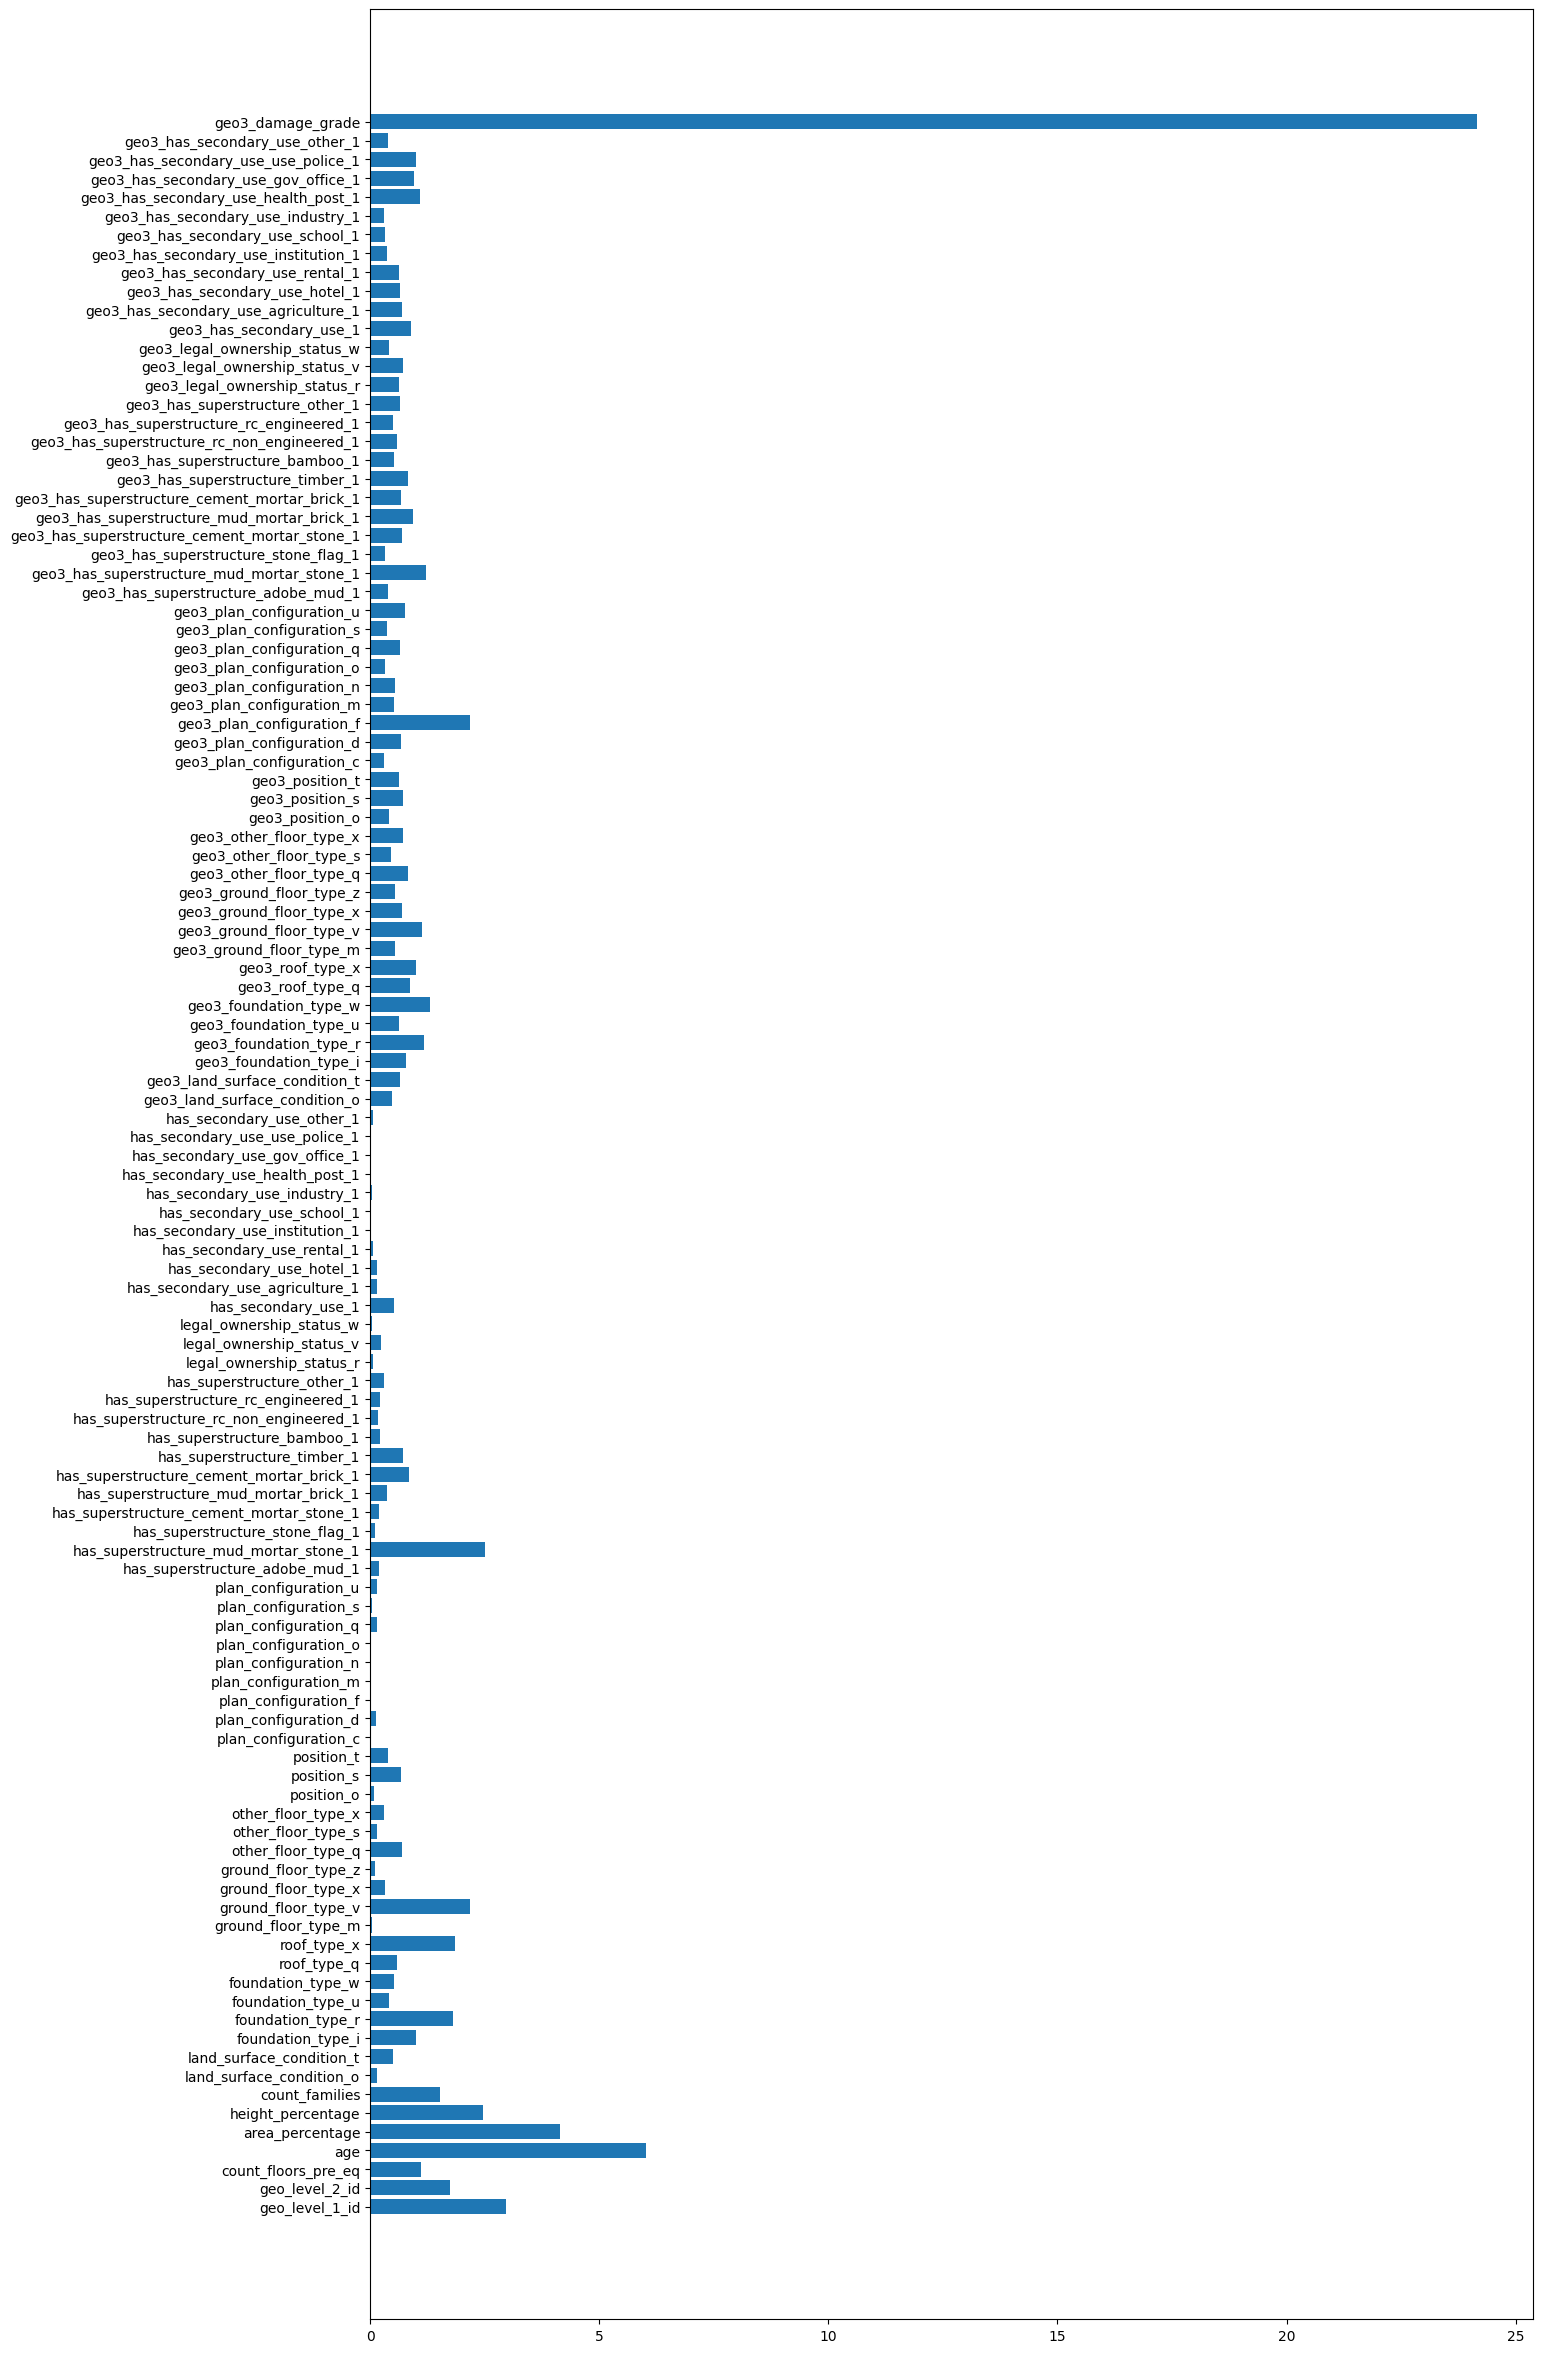

In [15]:
fig,ax = plt.subplots(1,1,figsize=(15,30))
feature_importance_vals = model.get_feature_importance()
ax.barh(X_train_geo_encode.columns,feature_importance_vals)

In [63]:
# import pickle
# with open('earthquake_cb_model_4_target_encode.pkl', 'wb') as f:
#     pickle.dump(model, f)

<BarContainer object of 38 artists>

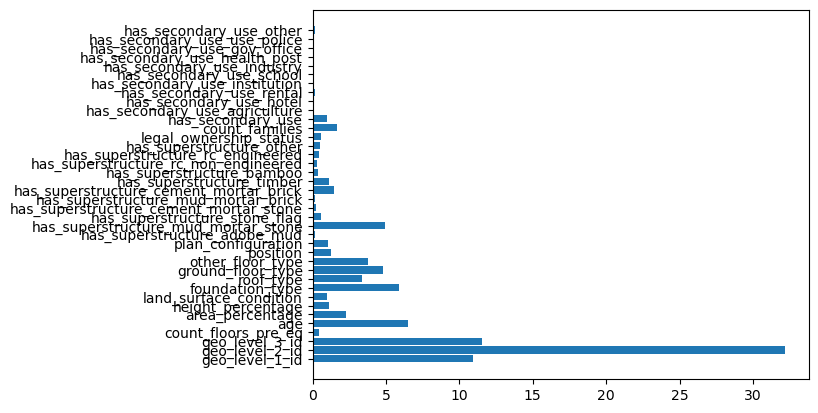

In [ ]:
# feature_importance_vals = model.get_feature_importance()
# plt.barh(X_train.columns,feature_importance_vals)
